In [4]:
import numpy as np
import torch
from torch import nn
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.autograd import Variable

w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return y[:, None], x[:, None]

y, x = load_dataset()

In [5]:
import seaborn as sns

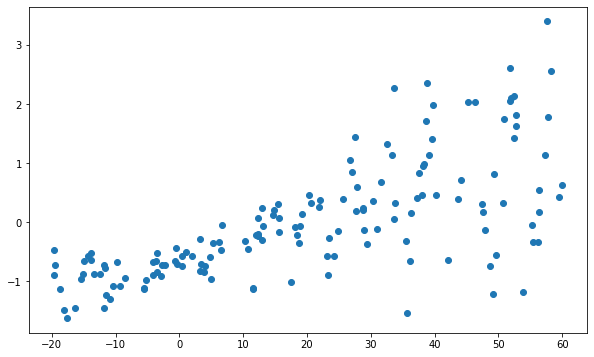

In [9]:
fig = plt.figure(figsize=[10,6])
plt.scatter(x, y)

In [10]:
# Go to pytorch world
X = torch.tensor(x, dtype=torch.float)
Y = torch.tensor(y, dtype=torch.float)

class MaximumLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.out = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.out(x)
    
epochs = 200
m = MaximumLikelihood()
optim = torch.optim.Adam(m.parameters(), lr=0.01)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = (0.5 * (y_pred - Y)**2).mean()
    loss.backward()
    optim.step()

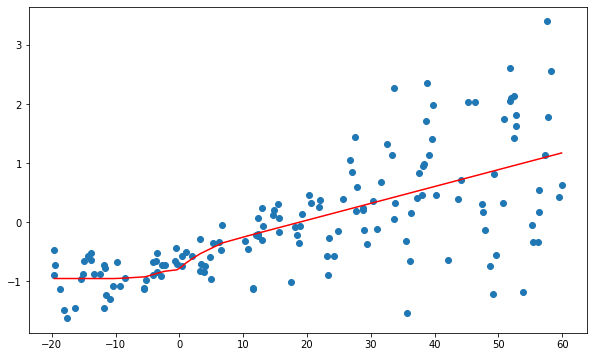

In [12]:
fig = plt.figure(figsize=[10,6])
plt.scatter(x, y)
plt.plot(x, y_pred.detach().numpy(), 'k-', color = 'r')
#plt.add_line(y_pred.detach().numpy())


In [13]:
class VI(nn.Module):
    def __init__(self, input=1, hidden=10):
        super().__init__()

        self.q_mu = nn.Sequential(
            nn.Linear(input, hidden*2),
            nn.ReLU(),
            nn.Linear(hidden*2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(input, hidden*2),
            nn.ReLU(),
            nn.Linear(hidden*2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def reparameterize(self, mu, log_var):
        # std can not be negative, thats why we use log variance
        sigma = torch.exp(0.5 * log_var) + 1e-5
        eps = torch.randn_like(sigma)
        return mu + sigma * eps

    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        return self.reparameterize(mu, log_var), mu, log_var

In [14]:
def ll_gaussian(y, mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    return -0.5 * torch.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2))* (y-mu)**2

In [15]:
def elbo(y_pred, y, mu, log_var):
    # likelihood of observing y given Variational mu and sigma
    likelihood = ll_gaussian(y, mu, log_var)
    
    # prior probability of y_pred
    log_prior = ll_gaussian(y_pred, 0, torch.log(torch.tensor(1.)))
    
    # variational probability of y_pred
    log_p_q = ll_gaussian(y_pred, mu, log_var)
    
    # by taking the mean we approximate the expectation
    return (likelihood + log_prior - log_p_q).mean()

def det_loss(y_pred, y, mu, log_var):
    return -elbo(y_pred, y, mu, log_var)

In [16]:
def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    
    return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [17]:
class AB(torch.nn.Module):
    def __init__(self, alpha, beta):
        super(AB, self).__init__()
        self.n_latent = 100 # Number of latent samples
        self.softplus = torch.nn.Softplus()
        self.alpha = alpha
        self.beta = beta
        
        #The parameters we adjust during training.
        self.qm = torch.nn.Parameter(torch.randn(1,1).double(), requires_grad=True)
        self.qs = torch.nn.Parameter(torch.randn(1,1).double(), requires_grad=True)
        
        #create holders for prior mean and std, and likelihood std.
        self.prior_m = torch.randn(1,1).double()
        self.prior_s = torch.randn(1,1).double()
        self.likelihood_s = torch.DoubleTensor((1))
        
        #Set the prior and likelihood moments.
        self.prior_s.data.fill_(1.0)
        self.prior_m.data.fill_(0.9)
        self.likelihood_s.data.fill_(5.5)

        
    def generate_rand(self):
        return np.random.normal(size=(self.n_latent,1))
    
    def reparam(self, eps):
        eps = Variable(torch.DoubleTensor(eps))
        return  eps.mul(self.softplus(self.qs)).add(self.qm)
    
    def compute_bound(self, x, t):
        eps = self.generate_rand()
        z = self.reparam(eps)
        q_likelihood = log_norm(z, self.qm, self.softplus(self.qs))
        prior = log_norm(z, self.prior_m, self.prior_s)
        likelihood = torch.sum(log_norm(t, x*z.transpose(0,1), self.likelihood_s), 0, keepdim=True).transpose(0,1)
        
        
        r1 = (self.alpha + self.beta)*(prior + likelihood) - q_likelihood
        c1 = torch.max(r1)
        exp1 = torch.exp((r1-c1))
        
        r2 = (self.alpha + self.beta -1)* q_likelihood
        c2 = torch.max(r2)
        exp2 = torch.exp((r2-c2))
        
        r3 = self.beta * (prior + likelihood) - (1- self.alpha) * q_likelihood
        c3 = torch.max(r3)
        exp3 = torch.exp((r3-c3))

        loss1 = (torch.log(torch.mean(exp1)) + c1) / ((self.beta + self.alpha) * self.alpha ) 
        loss2 = (torch.log(torch.mean(exp2)) + c2) / ((self.beta + self.alpha) * self.beta  ) 
        loss3 = (torch.log(torch.mean(exp3)) + c3) / (self.beta * self.alpha ) 
       
        return loss1 + loss2 + loss3
    

In [18]:
epochs = 1500

m = VI()
optim = torch.optim.Adam(m.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = det_loss(y_pred, Y, mu, log_var)
    loss.backward()
    optim.step()

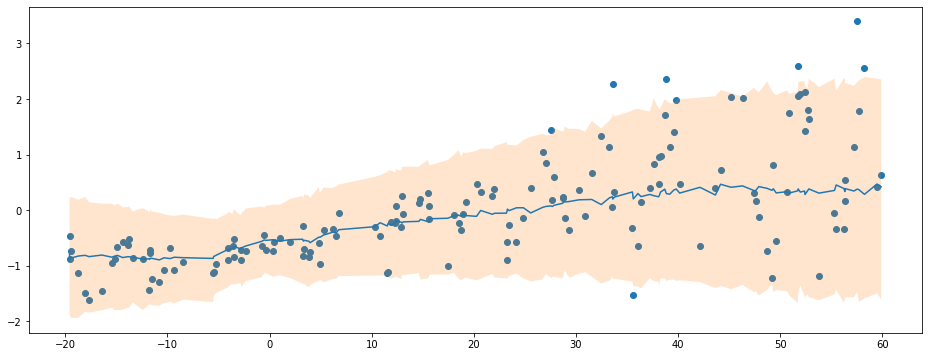

In [19]:
# draw samples from Q(theta)
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

plt.figure(figsize=(16, 6))
plt.scatter(X, Y)
plt.plot(X, mu)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)

In [ ]:
# Training using AB divergencee

In [ ]:
epochs = 2500

alphas = [-1, -0.5, -0.25, 0, 0.5, 1.0, 1.25, 1.5, 1.7, 2.]
betas = [-1, -0.5, -0.25, 0, 0.5, 1.0, 1.25, 1.5, 1.7, 2.]

losses = {}

for al in alphas:
    for be in betas:

        m = VI()
        optim = torch.optim.Adam(m.parameters(), lr=0.001)
        c = AB(alpha = al, beta = be)

        for epoch in range(epochs):
            optim.zero_grad()
            y_pred, mu, log_var = m(X)
            loss = -c.compute_bound(X, Y)
            loss.backward()
            optim.step()

            if epoch%500==0:
                print(loss.detach().numpy())
        losses[(al,be)] = loss

In [107]:
#losses

In [40]:
epochs = 3000
m = VI()
optim = torch.optim.Adam(m.parameters(), lr=0.005)
c = AB(alpha = 1.25, beta = -0.3)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = -c.compute_bound(X, Y)
    loss.backward()
    optim.step()

    if epoch%500==0:
        #print(loss.detach().numpy())
        print(c.qm.data.numpy(), (c.softplus(c.qs).data**2).numpy())

[[0.03982266]] [[1.06082483]]
[[0.03982266]] [[1.06082483]]
[[0.03982266]] [[1.06082483]]
[[0.03982266]] [[1.06082483]]
[[0.03982266]] [[1.06082483]]
[[0.03982266]] [[1.06082483]]


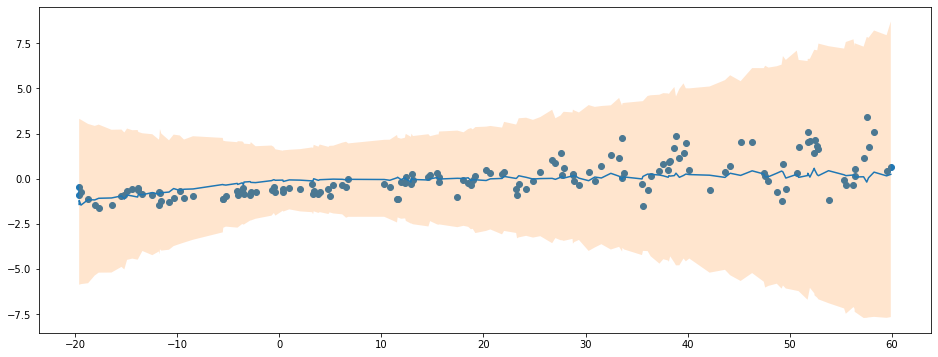

In [39]:
# draw samples from Q(theta)
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

plt.figure(figsize=(16, 6))
plt.scatter(X, Y)
plt.plot(X, mu)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)

In [41]:
class KL(torch.nn.Module):
    def __init__(self):
        super(KL, self).__init__()
        self.n_latent = 100 # Number of latent samples
        self.softplus = torch.nn.Softplus()
        
        #The parameters we adjust during training.
        self.qm = torch.nn.Parameter(torch.randn(1,1).double(), requires_grad=True)
        self.qs = torch.nn.Parameter(torch.randn(1,1).double(), requires_grad=True)
        
        #create holders for prior mean and std, and likelihood std.
        self.prior_m = torch.randn(1,1).double()
        self.prior_s = torch.randn(1,1).double()
        self.likelihood_s = torch.DoubleTensor((1))
        
        #Set the prior and likelihood moments.
        self.prior_s.data.fill_(1.0)
        self.prior_m.data.fill_(0.9)
        self.likelihood_s.data.fill_(5.5)

        
    def generate_rand(self):
        return np.random.normal(size=(self.n_latent,1))
    
    def reparam(self, eps):
        eps = Variable(torch.DoubleTensor(eps))
        return  eps.mul(self.softplus(self.qs)).add(self.qm)
    
    def compute_bound(self, x, t):
        eps = self.generate_rand()
        z = self.reparam(eps)
        q_likelihood = log_norm(z, self.qm, self.softplus(self.qs))
        prior = log_norm(z, self.prior_m, self.prior_s)
        likelihood = torch.sum(log_norm(t, x*z.transpose(0,1), self.likelihood_s), 0, keepdim=True).transpose(0,1)
        
        
        r1 = prior + likelihood -q_likelihood
        c1 = torch.max(r1)
        exp1 = torch.exp((r1-c1))
        
        KL_div = (torch.log(torch.mean(exp1)) + c1)
       
        return KL_div

In [42]:
class Renyi(torch.nn.Module):
    def __init__(self, alpha):
        super(Renyi, self).__init__()
        self.n_latent = 100 # Number of latent samples
        self.softplus = torch.nn.Softplus()
        self.alpha = alpha
        
        #The parameters we adjust during training.
        self.qm = torch.nn.Parameter(torch.randn(1,1).double(), requires_grad=True)
        self.qs = torch.nn.Parameter(torch.randn(1,1).double(), requires_grad=True)
        
        #create holders for prior mean and std, and likelihood std.
        self.prior_m = torch.randn(1,1).double()
        self.prior_s = torch.randn(1,1).double()
        self.likelihood_s = torch.DoubleTensor((1))
        
        #Set the prior and likelihood moments.
        self.prior_s.data.fill_(1.0)
        self.prior_m.data.fill_(0.9)
        self.likelihood_s.data.fill_(5.5)

        
    def generate_rand(self):
        return np.random.normal(size=(self.n_latent,1))
    
    def reparam(self, eps):
        eps = Variable(torch.DoubleTensor(eps))
        return  eps.mul(self.softplus(self.qs)).add(self.qm)
    
    def compute_bound(self, x, t):
        eps = self.generate_rand()
        z = self.reparam(eps)
        q_likelihood = log_norm(z, self.qm, self.softplus(self.qs))
        prior = log_norm(z, self.prior_m, self.prior_s)
        likelihood = torch.sum(log_norm(t, x*z.transpose(0,1), self.likelihood_s), 0, keepdim=True).transpose(0,1)
        
        r1 = (1-self.alpha)*(prior + likelihood -q_likelihood)
        c1 = torch.max(r1)
        exp1 = torch.exp((r1-c1))

        renyi_div = (torch.log(torch.mean(exp1))+c1)/(1-self.alpha)
        return renyi_div

In [ ]:
c = KL()

optimizer = torch.optim.Adam(c.parameters(),lr=0.01)
x = torch.tensor(X)
t = torch.tensor(T)

for i in range(20001):
    loss = -c.compute_bound(x, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 2500 ==0:
        print(c.qm.data.numpy(), (c.softplus(c.qs).data**2).numpy())

In [43]:
epochs = 3000
m = VI()
optim = torch.optim.Adam(m.parameters(), lr=0.005)
c = KL()

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = -c.compute_bound(X, Y)
    loss.backward()
    optim.step()

    if epoch%500==0:
        #print(loss.detach().numpy())
        print(c.qm.data.numpy(), (c.softplus(c.qs).data**2).numpy())

[[0.78867942]] [[0.75820043]]
[[0.78867942]] [[0.75820043]]
[[0.78867942]] [[0.75820043]]
[[0.78867942]] [[0.75820043]]
[[0.78867942]] [[0.75820043]]
[[0.78867942]] [[0.75820043]]


In [49]:
epochs = 3000
m = VI()
optim = torch.optim.Adam(m.parameters(), lr=0.005)
c = Renyi(alpha=0.5)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = -c.compute_bound(X, Y)
    loss.backward()
    optim.step()

    if epoch%500==0:
        #print(loss.detach().numpy())
        print(c.qm.data.numpy(), (c.softplus(c.qs).data**2).numpy())

[[-0.84772676]] [[0.78587492]]
[[-0.84772676]] [[0.78587492]]
[[-0.84772676]] [[0.78587492]]
[[-0.84772676]] [[0.78587492]]
[[-0.84772676]] [[0.78587492]]
[[-0.84772676]] [[0.78587492]]


**Boston Housing Dataset**


In [173]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



In [174]:
x, y = load_boston(return_X_y=True)

scaler = StandardScaler()
x_ = scaler.fit_transform(x)

X_train, X_val, y_train, y_val = train_test_split(x_, y, test_size=0.2)

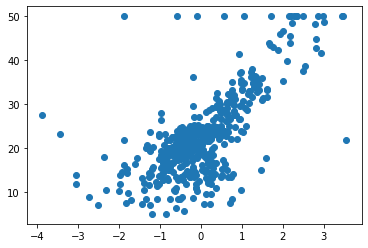

In [168]:
plt.scatter(x_[:,5], y)

In [181]:
y_pred.shape

torch.Size([404, 1])

In [196]:
X_train = torch.tensor(X_train, dtype=torch.float)
Y_train = torch.tensor(y_train, dtype=torch.float)

X_val = torch.tensor(X_val, dtype=torch.float)
Y_val = torch.tensor(y_val, dtype=torch.float)


# ELBO 
epochs = 5000
m = VI(13, 10)
optim = torch.optim.Adam(m.parameters(), lr=0.01)
#criterion = torch.nn.MSELoss()

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X_train)
    loss = det_loss(y_pred, Y, mu, log_var)
    #loss = criterion(y_pred, Y_train)
    loss.backward()
    optim.step()

    if epoch%500==0:
        print('Loss at epoch{}:{}'.format(epoch, loss))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Loss at epoch0:364.58544921875
Loss at epoch500:24.23806381225586
Loss at epoch1000:23.95490837097168
Loss at epoch1500:24.197996139526367
Loss at epoch2000:25.07879638671875
Loss at epoch2500:22.717714309692383
Loss at epoch3000:24.977493286132812
Loss at epoch3500:24.718374252319336
Loss at epoch4000:25.303466796875
Loss at epoch4500:24.699045181274414


In [197]:
# AB Divergence
epochs = 5000
m = VI(13, 10)
optim = torch.optim.Adam(m.parameters(), lr=0.01)
criterion = AB(alpha = 1.2, beta = -0.1)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X_train)
    loss = -criterion.compute_bound(X_train, y_pred)
    loss.backward()
    optim.step()

    if epoch%500==0:
        print('Loss at epoch{}:{}'.format(epoch, loss))

RuntimeError: ignored